In [ ]:
#load data set
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

data = pd.read_csv("https://drive.google.com/uc?id=1o0adqJ7RMP1M6Yr0XlgHmUgTMJtFoUZ_")
data.shape

(37126, 3)

In [ ]:
data = data.rename(columns={'users': 'User_ID'})
data = data.rename(columns={'items': 'Video_ID'})
data = data.rename(columns={'ratings': 'Rating'})
data.head()

,User_ID,Video_ID,Rating
0,A11N155CW1UV02,B000H00VBQ,2
1,A3BC8O2KCL29V2,B000H00VBQ,5
2,A60D5HQFOTSOM,B000H00VBQ,1
3,A1RJPIGRSNX4PW,B000H00VBQ,4
4,A16XRPF40679KG,B000H00VBQ,5


In [ ]:
def proc_col(col, train_col=None):
    #Encodes a pandas column with continuous ids.
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

def encodedata(df, train=None):
    df = df.copy()
    for col_name in ["User_ID", "Video_ID"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

data = encodedata(data)
data.head(10)

,User_ID,Video_ID,Rating
0,0,0,2
1,1,0,5
2,2,0,1
3,3,0,4
4,4,0,5
5,5,0,5
6,6,1,3
7,7,1,3
8,8,1,5
9,9,1,3


In [ ]:
#split out training, validation, and test dataset


np.random.seed(0)
msk1 = np.random.rand(len(data)) < 0.6
train = data[msk1].copy()
val = data[~msk1].copy()
msk = np.random.rand(len(val)) < 0.5
test = val[msk].copy()
val = val[~msk].copy()

data.info()
print(train.shape)
print(val.shape)
print(test.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   User_ID   37126 non-null  int64
 1   Video_ID  37126 non-null  int64
 2   Rating    37126 non-null  int64
dtypes: int64(3)
memory usage: 870.3 KB
(22483, 3)
(7396, 3)
(7247, 3)


In [ ]:
print(data.max())
userCount = data.max()[0] + 1
itemCount = data.max()[1] + 1
print(userCount, itemCount)

User_ID     5129
Video_ID    1684
Rating         5
dtype: int64
5130 1685


In [ ]:
ratings_train = [] * userCount

for i in range(userCount):
  ratings_train.append([0] * itemCount)

print(len(ratings_train), len(ratings_train[0]))

for ind, d in train.iterrows():
  id = int(d["User_ID"])
  vid = int(d["Video_ID"])
  rat = d["Rating"]
  ratings_train[id][vid] = rat

tmp = np.array(ratings_train).astype('float')
item_score=np.sum(tmp,axis=1)/(np.sum(tmp>0,axis=1)+1e-6)

for j in range(tmp.shape[1]):
  mask = tmp[:,j] == 0
  tmp[:,j][mask]=item_score[j]

rating_train = tmp
user_id = np.arange(userCount).reshape(-1, 1)

print(rating_train.shape)
print(user_id.shape)

5130 1685
(5130, 1685)
(5130, 1)


The smallest MSE of 1.739280411707327 is achieved at k = 13
The smallest MAE of 0.9488688917385774 is achieved at k = 10


Text(0, 0.5, 'MAE')

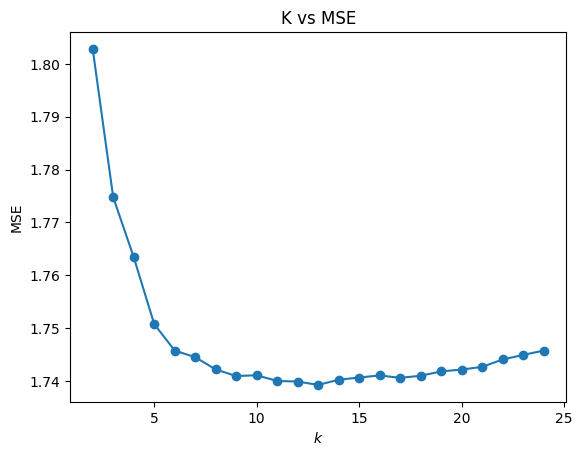

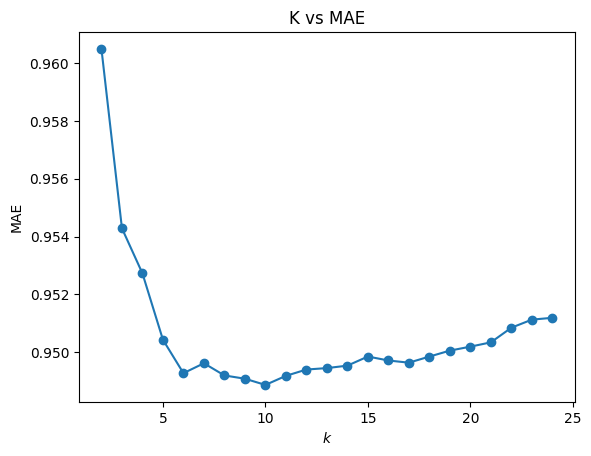

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as skm

ks = range(2, 25)
mse = []
mae = []

for k in ks:
  knnreg = KNeighborsRegressor(n_neighbors=k) # Create KNN model
  knnreg.fit(user_id, rating_train) # Fit the model to training data

  predicted = []
  validation = []
  for ind, d in val.iterrows():
    id = int(d["User_ID"])
    vid = int(d["Video_ID"])
    rat = d["Rating"]
    validation.append(rat)
    predicted.append(knnreg.predict(np.array(id).reshape(-1,1))[0][vid])

  predicted = np.array(predicted)
  validation = np.array(validation)
  mse.append(skm.mean_squared_error(validation, predicted))
  mae.append(skm.mean_absolute_error(validation, predicted))

bestMSE = min(mse)
bestInd = mse.index(bestMSE) + 2
print("The smallest MSE of", bestMSE, "is achieved at k =", bestInd)

bestMAE = min(mae)
bestInd = mae.index(bestMAE) + 2
print("The smallest MAE of", bestMAE, "is achieved at k =", bestInd)

# Plot
plt.figure()
plt.title("K vs MSE")
plt.plot(ks, mse, 'o-')
plt.xlabel(r'$k$')
plt.ylabel("MSE")

plt.figure()
plt.title("K vs MAE")
plt.plot(ks, mae, 'o-')
plt.xlabel(r'$k$')
plt.ylabel("MAE")

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as skm

k = 10
knnreg = KNeighborsRegressor(n_neighbors=k) # Create KNN model
knnreg.fit(user_id, rating_train) # Fit the model to training data

predicted = []
testing = []
for ind, d in test.iterrows():
  id = int(d["User_ID"])
  food = int(d["Video_ID"])
  rat = d["Rating"]
  testing.append(rat)
  predicted.append(knnreg.predict(np.array(id).reshape(-1,1))[0][food])

predicted = np.array(predicted)
testing = np.array(testing)

print("MSE: ", skm.mean_squared_error(testing, predicted))
print("MAE: ", skm.mean_absolute_error(testing, predicted))

MSE:  1.6966279684530325
MAE:  0.9340277251318589
